In [145]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re

In [146]:
arg_component_balance=True
arg_add_new_dataset=False
arg_add_transformer=False

In [147]:
result_path = '/data/coding/chaochuan/TSGym/meta/results'
datasets = ['ETTh1', 'ETTh2', 'ETTm1', 'ETTm2', 'ili', 'weather', 'ECL', 'Exchange', 'traffic']
if arg_add_new_dataset:
    datasets.extend(['covid-19', 'fred-md'])
file_list = [f'{dataset}-component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.npz' for dataset in datasets]

print(len(file_list))

9


In [148]:
# sota performance
def search_sota_performance(dataset, pred_lens=[96], path = '/data/coding/chaochuan/TSGym/results'):
    result_dict = {}
    for pred_len in pred_lens:
        model_list = os.listdir(path)
        model_list = [_ for _ in model_list if f'pl{pred_len}' in _ and dataset in _]
        result_dict[pred_len] = {}
        for model in model_list:
            result = np.load(os.path.join(path, model, 'metrics.npy'), allow_pickle=True)
            result_dict[pred_len][model] = result[1]

    df = pd.DataFrame.from_dict(result_dict[pred_lens[0]], orient='index')
    df.columns = ['mse']
    df = df.sort_values(by='mse')
    df.index = [_.split('_')[6] for _ in df.index]

    return df

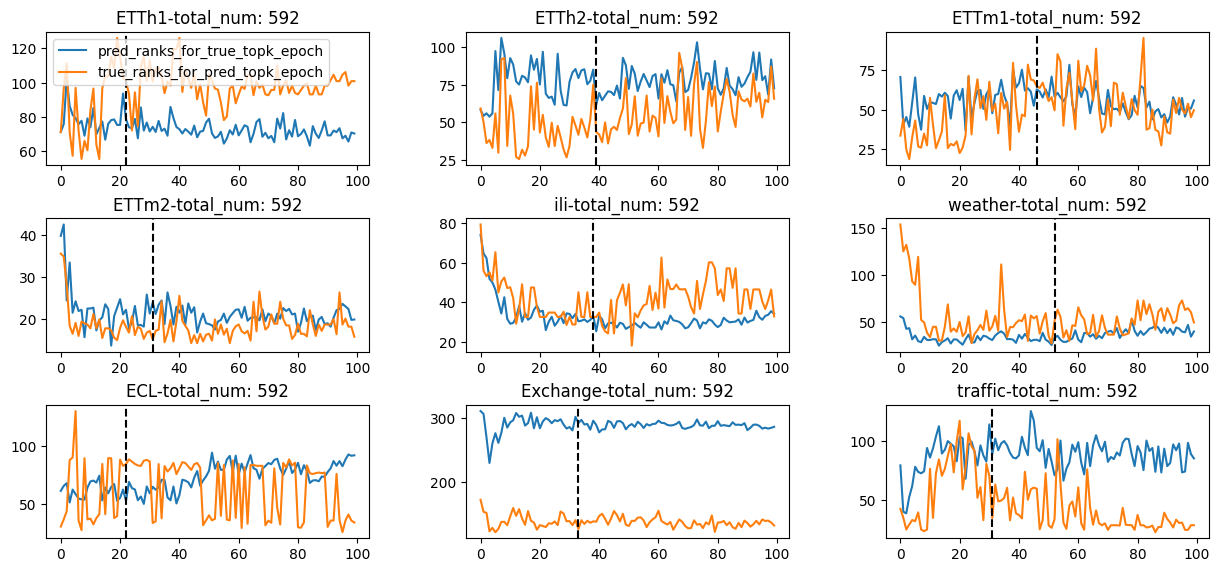

In [149]:
fig = plt.figure(figsize=(15, 9))
for i, file in enumerate(file_list):
    try:
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        # print(perf_epoch.files)

        fig.add_subplot(4, 3, i+1)
        for _ in perf_epoch.files:
            if _ in ['pred_ranks_for_true_topk_epoch', 'true_ranks_for_pred_topk_epoch']:
                plt.plot(perf_epoch[_], label=_)
            elif _ == 'total_num':
                plt.title(f'{file.replace(".npz", "").split("-")[0]}-total_num: {perf_epoch[_]}')
            elif _ == 'best_epoch':
                plt.axvline(perf_epoch['best_epoch'].item(), color='black', linestyle='--')
            else:
                pass 

        if i==0: plt.legend()
    except:
        continue

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

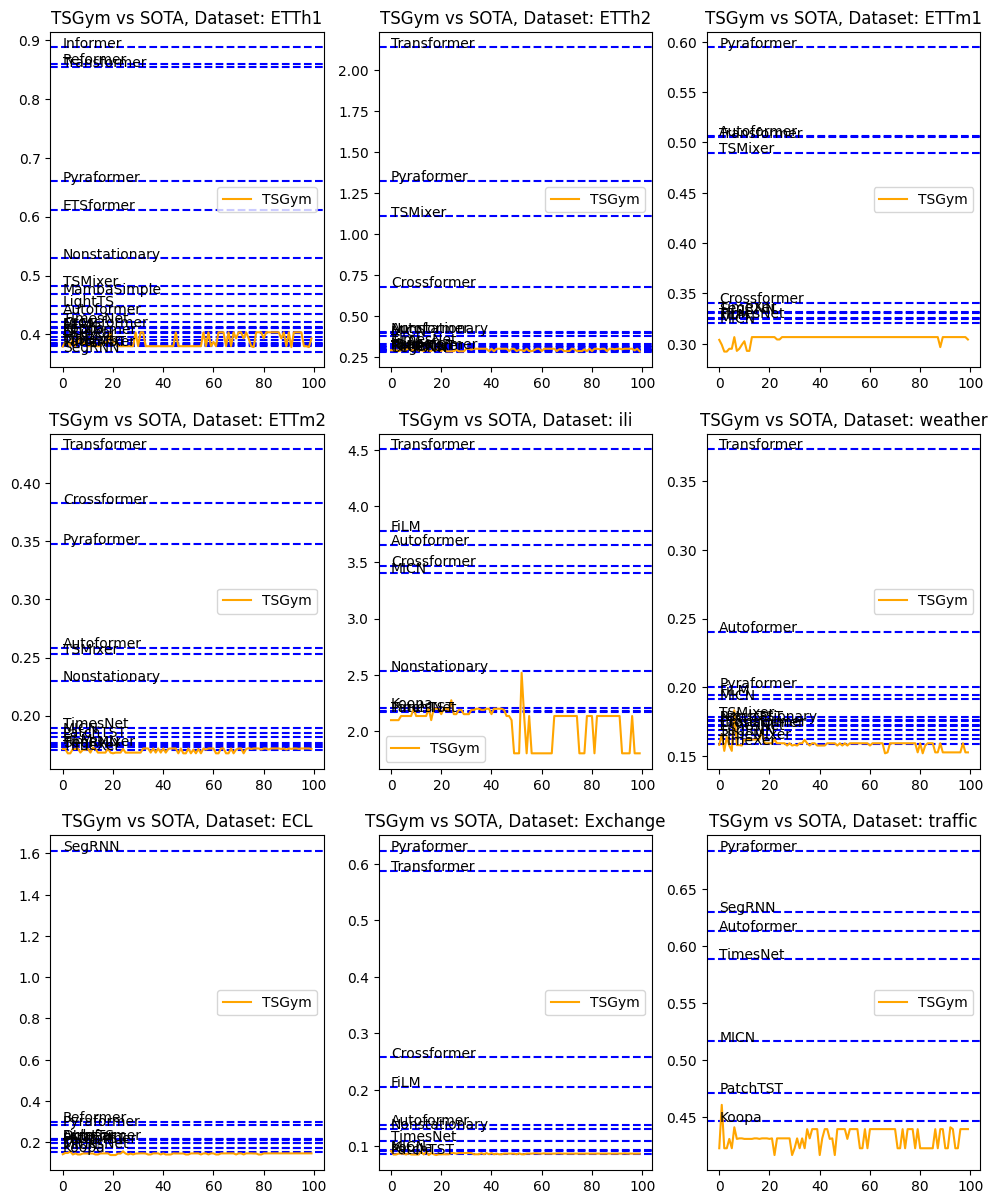

In [150]:
fig = plt.figure(figsize=(12, 20))
for i, file in enumerate(file_list):
    try:
        dataset = file[:re.search('-component', file).start()]
        if dataset in ['ili', 'covid-19', 'fred-md']:
            df = search_sota_performance(dataset, pred_lens=[24])
        else:
            df = search_sota_performance(dataset)
        # except:
        #     continue
        fig.add_subplot(4, 3, i+1)
        for model, metric in df.iterrows():
            plt.axhline(y=metric.item(), color='blue', linestyle='--')
            plt.text(0, metric.item(), model, color='black')

        # 添加图例和标题
        perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
        top1_perf_epoch = perf_epoch['top1_perf_epoch']
        plt.plot(top1_perf_epoch, color='orange', label='TSGym')

        plt.legend()
        plt.title(f'TSGym vs SOTA, Dataset: {dataset}')
    except:
        continue

plt.show()

In [151]:
# TSGym vs best sota
dfs, ranks = [], []
for i, file in enumerate(file_list):
    # dataset = file.split('-')[0]
    dataset = file[:re.search('-component', file).start()]


    if dataset in ['ili', 'covid-19', 'fred-md']:
        df = search_sota_performance(dataset, pred_lens=[24])
    else:
        df = search_sota_performance(dataset)


    # 添加图例和标题
    perf_epoch = np.load(os.path.join(result_path, file), allow_pickle=True)
    top1_perf_epoch = perf_epoch['top1_perf_epoch']

    df.loc['TSGym'] = top1_perf_epoch[perf_epoch['best_epoch'].item()]
    df = df.sort_values(by='mse')
    df = df.reset_index()
    df.columns = ['model', dataset]
    df = df.iloc[:10, :]
    ranks.append((np.where(df['model'] == 'TSGym')[0] + 1).item())
    dfs.append(df)

dfs = pd.concat(dfs, axis=1)
print(f'平均排名: {np.mean(ranks)}')
dfs

平均排名: 1.5555555555555556


,model,ETTh1,model,ETTh2,model,ETTm1,model,ETTm2,model,ili,model,weather,model,ECL,model,Exchange,model,traffic
0,SegRNN,0.370867,SegRNN,0.282564,TSGym,0.306719,TSGym,0.168073,PatchTST,2.168191,TimeXer,0.158659,TSGym,0.144934,TSGym,0.085815,TSGym,0.431602
1,TSGym,0.380060,TSGym,0.285375,MICN,0.320593,TimeXer,0.170625,TimesNet,2.174988,TSGym,0.159399,Koopa,0.152825,PatchTST,0.086641,Koopa,0.446586
2,PatchTST,0.380158,TimeXer,0.287365,FiLM,0.324987,SegRNN,0.172851,TSGym,2.198923,TimeMixer,0.162554,MICN,0.170311,Koopa,0.091252,PatchTST,0.471588
3,TimeMixer,0.381575,TimeMixer,0.291129,TimesNet,0.325995,TimeMixer,0.174330,Koopa,2.209361,SegRNN,0.165622,TimesNet,0.172471,MICN,0.092951,MICN,0.516740
4,TimeXer,0.383762,PatchTST,0.295004,SegRNN,0.330613,FiLM,0.176033,Nonstationary,2.537160,TimesNet,0.169092,PatchTST,0.196937,TimesNet,0.109883,TimesNet,0.589141
5,TiDE,0.384989,iTransformer,0.300953,TimeXer,0.331773,PatchTST,0.181935,MICN,3.408669,Crossformer,0.171791,FEDformer,0.197375,Nonstationary,0.130638,Autoformer,0.613174
6,PAttn,0.391195,Koopa,0.308469,Crossformer,0.340736,MICN,0.185391,Crossformer,3.470287,iTransformer,0.172495,DLinear,0.210297,Autoformer,0.137937,SegRNN,0.630063
7,DLinear,0.395788,FiLM,0.316959,TSMixer,0.489369,TimesNet,0.189387,Autoformer,3.657251,PatchTST,0.175675,Autoformer,0.213805,FiLM,0.204847,Pyraformer,0.683659
8,FEDformer,0.401848,TimesNet,0.328028,Transformer,0.505069,Nonstationary,0.230007,FiLM,3.782863,Nonstationary,0.175962,LightTS,0.214226,Crossformer,0.257572,NaN,NaN
9,Koopa,0.403704,MICN,0.379799,Autoformer,0.506288,TSMixer,0.253285,Transformer,4.507895,TSMixer,0.178758,Pyraformer,0.281390,Transformer,0.587760,NaN,NaN


In [152]:
dfs.to_excel(f'/data/coding/chaochuan/TSGym/meta/component_balance_{arg_component_balance}-add_new_dataset_{arg_add_new_dataset}-add_transformer_{arg_add_transformer}.xlsx', index=False)


meta-feature的差异性

In [153]:
# meta_feature_path = '/data/coding/chaochuan/TSGym/meta_learner_cc/meta_feature_copy/meta_feature'

In [154]:
# meta_features_dict = {}
# for file in os.listdir(meta_feature_path):
#     if file.endswith('.npz'):
#         meta_feature = np.load(os.path.join(meta_feature_path, file), allow_pickle=True)
#         meta_features_dict[file.replace('.npz', '').replace('meta_feature_', '')] = meta_feature['meta_feature']

In [155]:
# meta_features = np.stack(list(meta_features_dict.values()))
# meta_features = np.clip(meta_features, -1e4, 1e4)

# # z-score
# mu = np.nanmean(meta_features, axis=0, keepdims=True)
# std = np.nanstd(meta_features, axis=0, keepdims=True)

# meta_features = (meta_features - mu) / (std + 1e-6)
# meta_features = np.nan_to_num(meta_features, nan=0.0)

In [156]:
# fig = plt.figure(figsize=(20, 20))

# for seed in range(1, 5):
#     tsne = TSNE(n_components=2, random_state=seed, perplexity=10)
#     meta_features_tsne = tsne.fit_transform(meta_features) 
#     meta_features_dict_tsne = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_tsne)}
#     fig.add_subplot(2, 2, seed)
#     for k, v in meta_features_dict_tsne.items():
#         plt.scatter(v[0], v[1])
#         plt.text(v[0], v[1], k, fontsize=12)
# fig.suptitle('TSNE', fontsize=16)
# plt.show()


In [157]:
# fig = plt.figure(figsize=(20, 20))

# pca = PCA(n_components=2, random_state=42)
# meta_features_pca = pca.fit_transform(meta_features) 
# meta_features_dict_pca = {k: v for k, v in zip(meta_features_dict.keys(), meta_features_pca)}
# for k, v in meta_features_dict_pca.items():
#     plt.scatter(v[0], v[1])
#     plt.text(v[0], v[1], k, fontsize=16)
# plt.title('PCA', fontsize=16)
# plt.show()
